# A maximally simple solution to CT / CTA detection!

In [1]:
import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
pd.set_option('precision', 2)
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
import os
from glob import glob

import keras
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.models import Sequential, model_from_json

from skimage.transform import downscale_local_mean
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading DICOM from the SHAIP environment

In [3]:
SMILY = u'\U0001F603'

In [4]:
class ShaipWorkspace(object):
    """ 
    This trivial class represents the shape (sic) of the SHAIP workspace,
    Defining where to find input datasets and GT, where to save results
    and models and where to find cache storage.  These are all Docker
    container local file paths.   
    """
    def __init__(self):
        " "
        self.data_dir =           'ShaipWorkspace/inputs/dicomdata/'    # Will change
        self.groundtruth_dir =    'ShaipWorkspace/inputs/groundtruth/'  # Not yet used (taken from filename!)
        self.results_dir =        'ShaipWorkspace/outputs/results/'
        self.models_dir =          'ShaipWorkspace/outputs/models/'
        self.tensorboad_dir =     'ShaipWorkspace/outputs/tensorboard/' # Not yet used
        self.cache_dir =          'ShaipWorkspace/cache/'               # not yet used
        

In [5]:
class Cohort(object):
    """ 
    Manages a SHAIP-like cohort of datasets, finding what datasets are available, reading data and GT.
    Deals only with the raw input data - no normalization happens here.  
    Accessors generally present lazy evaluation semantics.
    """
    def __init__(self, shaip):
        """ The constructor scans the data path to find what data is present and
        setup a list and dictionary of dataset ids and paths.  It does not *read*
        the data"""
        self.shaip = shaip
        self.filepaths = glob(self.shaip.data_dir + '*.dcm')
        self.ids = [os.path.basename(fp)[:7] for fp in self.filepaths]
        self.id_to_path_map = {id: path for id, path in zip(self.ids, self.filepaths)}
        self.size = len(self.ids)
        
        # Private cache storage
        self._images = self._dicoms = self._groundtruth = None
        
    @property
    def dicoms(self):
        """ Lazily read and return a list of dicom objects in the same order as self.ids """
        if self._dicoms is None:
            self._dicoms = [pydicom.dcmread(fp) for fp in self.filepaths]
        return self._dicoms
        
    @property
    def images(self):
        """ Lazily extract and a list of images (2d numpy arrays) in the same order as self.ids """
        if self._images is None:
            self._images = [dcm.pixel_array for dcm in self.dicoms]
        return self._images
    
    @staticmethod
    def _filename_to_contrast_gt(fname):
        """ Filenames look like this: "ID_0087_AGE_0044_CONTRAST_0_CT.dcm """
        assert fname[17:25] == 'CONTRAST'
        c = fname[26]
        assert c in ('0', '1')
        return int(c)
        
    @property
    def groundtruth(self):
        """ Return a list of ground-truth values as {0, 1} integers in the same order as self.ids"""
        if self._groundtruth is None:
            self._groundtruth = [Cohort._filename_to_contrast_gt(os.path.basename(fp)) for fp in self.filepaths]
        return self._groundtruth
            

def test_cohort_init():
    cohort = Cohort(ShaipWorkspace())
    # print(datasets.ids)
    # print(datasets.id_to_path_map)
    assert len(cohort.ids) == 100
    assert len(cohort.ids[0]) == 7 and cohort.ids[0][:3] == 'ID_'
    assert os.path.exists(cohort.filepaths[0])
    print(SMILY, "test_cohort_init passed.")
    
def test_cohort_accessors():
    cohort = Cohort(ShaipWorkspace())
    assert len(cohort.dicoms) == len(cohort.ids) == len(cohort.images) == \
           len(cohort.groundtruth) == len(cohort.groundtruth) == len(cohort.filepaths) == cohort.size
    assert all(['PixelData' in dcm for dcm in cohort.dicoms])
    assert len(cohort.images) == len(cohort.ids)
    assert all([im.shape == (512, 512) for im in cohort.images])
    assert all([im.dtype in (np.int16, np.uint16) for im in cohort.images])
    assert all([gt in (0,1) for gt in cohort.groundtruth])
    print(SMILY, "test_cohort_accessors passed.")
                    
def test__filename_to_contrast_gt():
    fname = 'ID_0087_AGE_0044_CONTRAST_0_CT.dcm'
    gt = Cohort._filename_to_contrast_gt(fname)
    assert gt == 0
    print(SMILY, "test__filename_to_contrast_gt passed.")
    

test__filename_to_contrast_gt()
test_cohort_init()
test_cohort_accessors()
    

😃 test__filename_to_contrast_gt passed.
😃 test_cohort_init passed.
😃 test_cohort_accessors passed.


In [16]:
def explore_cohort(cohort, savefilename=None):
    df = pd.DataFrame(columns=['ID', 'GT', 'MinV', 'MaxV', 'Slope', 'Incpt', 'MmPerPix', 'Padding'])
    for ix in range(cohort.size):
        image = cohort.images[ix]
        dcm = cohort.dicoms[ix]
        id_ = cohort.ids[ix]
        gt = cohort.groundtruth[ix]
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        mmpp_x, mmpp_y = dcm.data_element('PixelSpacing').value
        assert mmpp_x == mmpp_y
        row = (id_, gt, np.min(image), np.max(image), slope, intercept, mmpp_x, padding)

        df.loc[ix] = row
        
    display(df.describe(include='all'))
    display(df)
    if savefilename is not None:
        with open(cohort.shaip.results_dir + savefilename, 'w') as fp:
            df.to_html(fp)
        
explore_cohort(Cohort(ShaipWorkspace()), 'summary.html')

,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
count,100,100.0,100.0,100.0,1.00e+02,100.00,100.00,33.0
unique,100,2.0,4.0,77.0,NaN,NaN,NaN,2.0
top,ID_0025,1.0,0.0,4095.0,NaN,NaN,NaN,-2000.0
freq,1,50.0,66.0,17.0,NaN,NaN,NaN,21.0
mean,NaN,NaN,NaN,NaN,1.00e+00,-1013.76,0.73,NaN
std,NaN,NaN,NaN,NaN,7.67e-05,102.40,0.13,NaN
min,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.54,NaN
25%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.65,NaN
50%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.70,NaN
75%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.77,NaN


,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
0,ID_0000,1,0,1918,1.0,-1024.0,0.78,None
1,ID_0001,1,0,4089,1.0,-1024.0,0.64,None
2,ID_0002,1,0,2413,1.0,-1024.0,0.55,None
3,ID_0003,1,0,2228,1.0,-1024.0,0.65,None
4,ID_0004,1,0,2141,1.0,-1024.0,0.67,None
5,ID_0005,1,0,3024,1.0,-1024.0,0.64,None
6,ID_0006,1,0,2228,1.0,-1024.0,0.65,None
7,ID_0007,1,5,2208,1.0,-1024.0,0.54,None
8,ID_0008,1,-2000,2428,1.0,-1024.0,0.78,-2000
9,ID_0009,1,0,4095,1.0,-1024.0,0.59,None


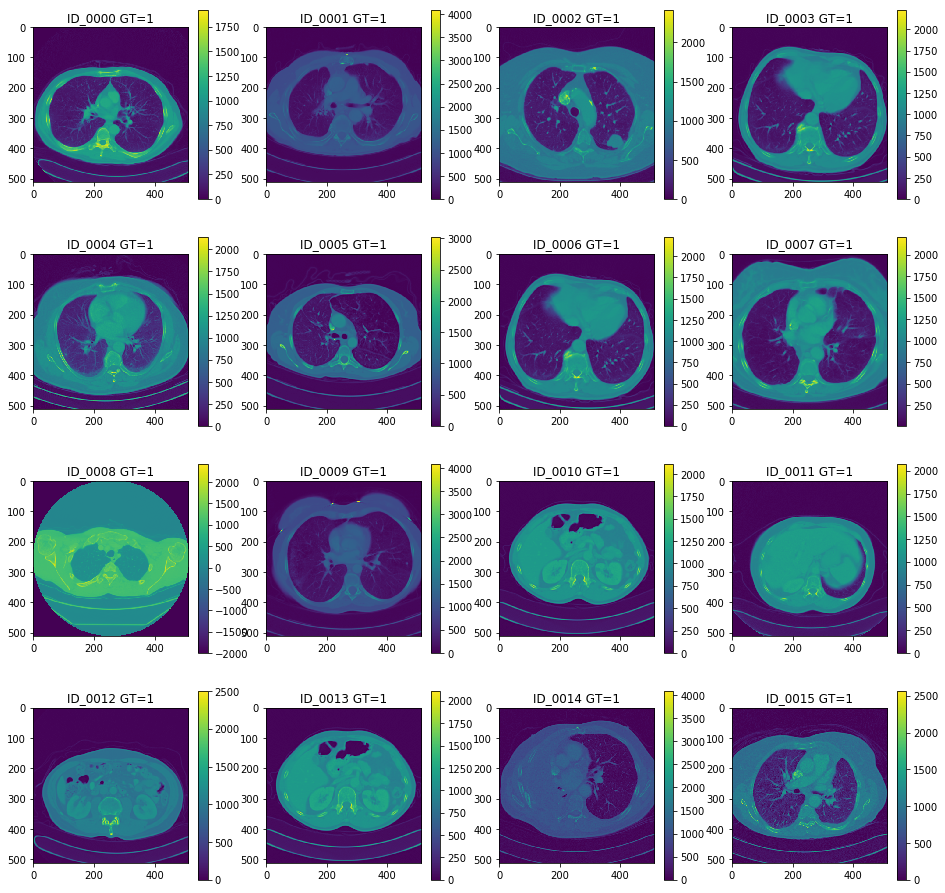

In [17]:
def show_images(cohort, savefilename = None):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
    for ix, ax in enumerate(axes.flat):   # Show just a selection
        im = cohort.images[ix]
        gt = cohort.groundtruth[ix]
        pltim = ax.imshow(im)
        ax.set_title("%s GT=%d"% (cohort.ids[ix], gt))
        cbar=fig.colorbar(pltim, ax=ax)
    if savefilename is not None:
        plt.savefig(cohort.shaip.results_dir + savefilename)
    plt.show()
        
show_images(Cohort(ShaipWorkspace()), 'example_images.png')

## Preprocessing

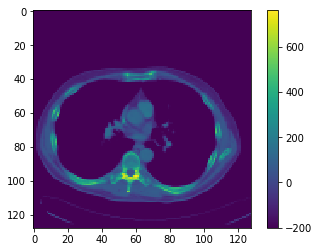

😃 test__preprocess_one_dicom passed.
😃 test_preprocessed_cohort_accessors passed.


In [18]:
class PreprocessedCohort(object):
    """ 
    Represents cohort of data with basic pre-procession applied.  For example, deal with padding,
    conversion to Hounsfield etc.  At this stage we are no longer concerned with file formats, directories
    etc.
    """
    downsample_factor = (4, 4)
    imshape = tuple(512//dsf for dsf in downsample_factor)  # e.g. (128, 128)
    
    def __init__(self, cohort):
        dicoms = cohort.dicoms
        
        self.size = cohort.size   # Number of images
        self.ids = cohort.ids
        self.groundtruth = cohort.groundtruth
        self.dicoms = cohort.dicoms
        
        self._preprocessed_images = None
        
    def _preprocess_one_dicom(self, dcm):
        """ Return a nicely normalised numpy float32 image """
        raw_image = dcm.pixel_array
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        # print(raw_image.dtype)
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        
        image = np.array(raw_image, dtype=np.float32)
        image = image * slope + intercept
        image = np.array(image, dtype=np.float32)
       
        # It seems that padding value lies!  So we'll just clamp image values and hope for the best!
        # print("Image (min,max) = (%6.1f, %6.1f)" % (np.min(image), np.max(image)))
        clip_min = -200.0
        clip_max = 1000.0
        image[image < clip_min] = clip_min
        image[image > clip_max] = clip_max
            
        assert np.min(image) >= clip_min
        assert np.max(image) <= clip_max
        
        # Finally, downscale !
    
        image = downscale_local_mean(image, self.downsample_factor)
            
        return image
        
        
    @property
    def images(self):
        """ Lazily apply normalisation """
        if self._preprocessed_images is None:
            self._preprocessed_images = [self._preprocess_one_dicom(dcm) for dcm in self.dicoms]
        return self._preprocessed_images
    
def test__preprocess_one_dicom():
    cohort = Cohort(ShaipWorkspace())
    ppch = PreprocessedCohort(cohort)
    dcm1 = cohort.dicoms[0]
    image = ppch._preprocess_one_dicom(dcm1)
    assert image.shape == PreprocessedCohort.imshape
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    print(SMILY, "test__preprocess_one_dicom passed.")
    
def test_preprocessed_cohort_accessors():
    ppch = PreprocessedCohort(Cohort(ShaipWorkspace()))
    assert len(ppch.images) == len(ppch.ids) == len(ppch.groundtruth) == ppch.size
    print(SMILY, "test_preprocessed_cohort_accessors passed.")
    
test__preprocess_one_dicom()
test_preprocessed_cohort_accessors()

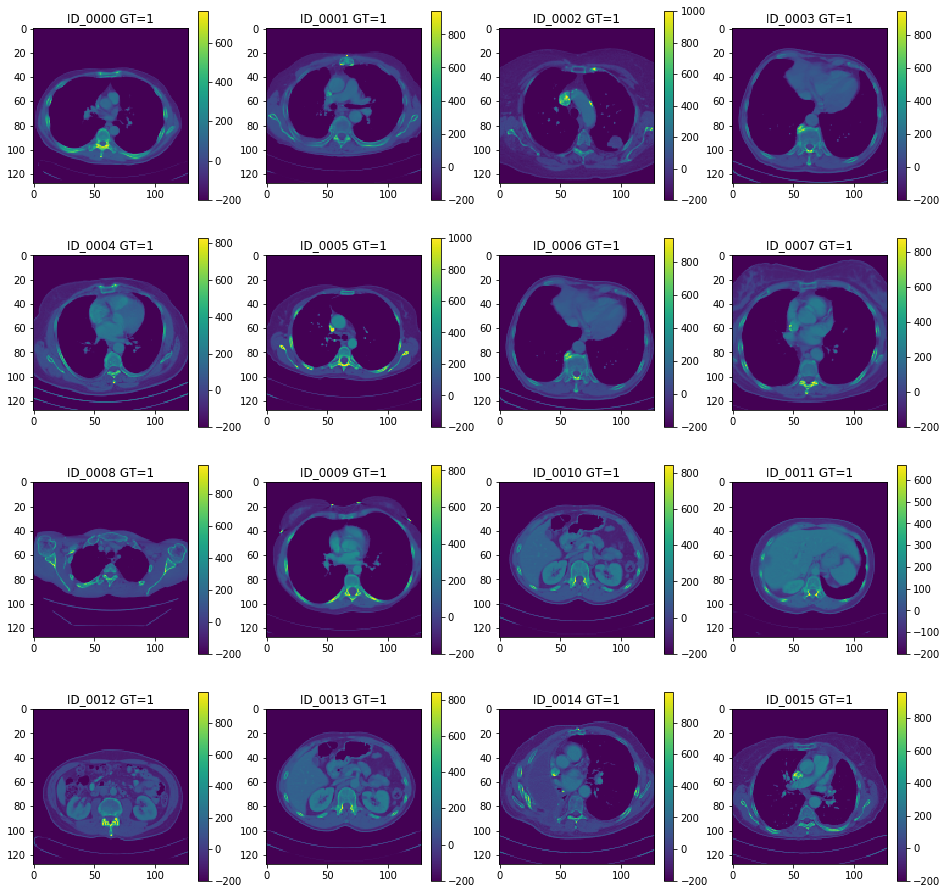

In [19]:
show_images(PreprocessedCohort(Cohort(ShaipWorkspace())))

## Dataset train / test split and preparation for learning

In [20]:
def data_scaling(images):
    """
    Given a list of pre-processed images (e.g. from PreprocessedCohort.images) perform
    intensity scaling and reshaping, returning a 4D tensor (n, x, y, 1) ready for feeding to a network
    """
    
    siz = images[0].shape
    x_data = np.array(images).reshape(-1, siz[0], siz[1], 1)
    x_data = x_data.astype(np.float32)
    x_data = (x_data + 100) / 150.0
    mean, sd = np.mean(x_data), np.std(x_data)
    min_, max_ = np.min(x_data), np.max(x_data)
    print("data_scaling: shape:", x_data.shape, "min,max:", (min_, max_), "mean,sd:", (mean, sd))
    
    return x_data

def test_data_scaling():
    xs, ys = 64, 128
    im = np.random.uniform(size=(xs, ys),high=2000, low=-300)
    n = 3
    images = [im] * n  # test set of just 3 images
    x_data = data_scaling(images)
    expected_shape = (n, xs, ys, 1)
    assert x_data.shape == expected_shape
    assert x_data.dtype == np.float32
    
test_data_scaling()

data_scaling: shape: (3, 64, 128, 1) min,max: (-1.3330243, 13.998013) mean,sd: (6.441858, 4.427442)


## Convolutional Neural Network Model

In [21]:
def build_model(image_shape):
    input_shape = image_shape + (1,)  # e.g. (128, 128, 1)
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(8, (3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

def test_build_model():
    model = build_model((128, 128))
    model.summary()
    print(SMILY, "test_build_model passed.")

test_build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 8)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                32010     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
__________

In [22]:
import h5py
def save_model(model, fname):
    """ Save model and wieghts to fname and fname.h5 files respectively 
    fname can include a directory which will be created if it doesn't exist"""
    
    directory = os.path.dirname(fname)
    if directory and not os.path.isdir(directory):
        print("Creating directory %s" % directory)
        os.makedirs(directory)
        
    model_json = model.to_json()
    with open(fname+'.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(fname+'.h5')
    print("Model saved to %s[.json,.h5] files" % fname)

def load_model(fname):
    """ Load a model from fname.json and fname.h5, and return it. 
    (Note that the loaded model must be compiled before use)"""
    # load json and create model
    json_file = open(fname+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fname + '.h5')
    print("Loaded model from %s[.json,.h5] files" % fname)
    return loaded_model

def test_model_save_and_load():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(5, 1)))
    save_model(model, 'gash/test_model')
    model2 = load_model('gash/test_model')
    print(SMILY, "test_model_save_and_load passed.")
    
test_model_save_and_load()

Model saved to gash/test_model[.json,.h5] files
Loaded model from gash/test_model[.json,.h5] files
😃 test_model_save_and_load passed.


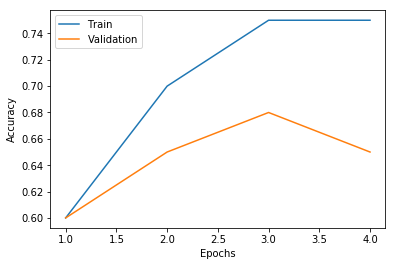

In [23]:
class AccuracyHistory(keras.callbacks.Callback):
    """ Record and plot training progress """
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
    def plot_training(self):
        epochs = range(1, len(self.acc)+1)
        plt.plot(epochs, self.acc, label='Train')
        plt.plot(epochs, self.val_acc, label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
def test_AccuraryHistory():
    history = AccuracyHistory()
    
    # Simulate some training!
    history.on_train_begin()
    for epoch, acc, val_acc in zip([1,2,3,4], [.6,.7,.75,.75],[.6,.65,.68,.65]):
        log = {'acc':acc, 'val_acc':val_acc}
        history.on_epoch_end(epoch, log)
        
    history.plot_training()
    
test_AccuraryHistory()

## Experiment - putting it all together

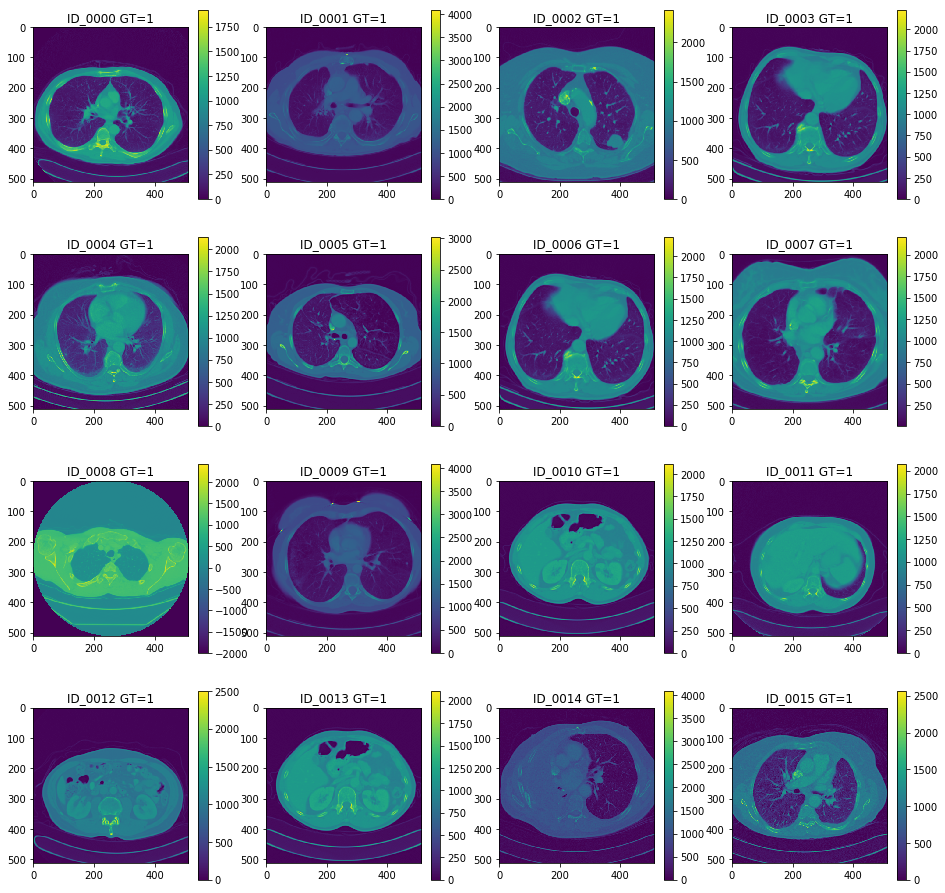

,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
count,100,100.0,100.0,100.0,1.00e+02,100.00,100.00,33.0
unique,100,2.0,4.0,77.0,NaN,NaN,NaN,2.0
top,ID_0025,1.0,0.0,4095.0,NaN,NaN,NaN,-2000.0
freq,1,50.0,66.0,17.0,NaN,NaN,NaN,21.0
mean,NaN,NaN,NaN,NaN,1.00e+00,-1013.76,0.73,NaN
std,NaN,NaN,NaN,NaN,7.67e-05,102.40,0.13,NaN
min,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.54,NaN
25%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.65,NaN
50%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.70,NaN
75%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.77,NaN


,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
0,ID_0000,1,0,1918,1.0,-1024.0,0.78,None
1,ID_0001,1,0,4089,1.0,-1024.0,0.64,None
2,ID_0002,1,0,2413,1.0,-1024.0,0.55,None
3,ID_0003,1,0,2228,1.0,-1024.0,0.65,None
4,ID_0004,1,0,2141,1.0,-1024.0,0.67,None
5,ID_0005,1,0,3024,1.0,-1024.0,0.64,None
6,ID_0006,1,0,2228,1.0,-1024.0,0.65,None
7,ID_0007,1,5,2208,1.0,-1024.0,0.54,None
8,ID_0008,1,-2000,2428,1.0,-1024.0,0.78,-2000
9,ID_0009,1,0,4095,1.0,-1024.0,0.59,None


data_scaling: shape: (100, 128, 128, 1) min,max: (-0.6666667, 7.3333335) mean,sd: (-0.10456283, 0.8816934)
Training set: 42 class 0, 38 class 1
Testing set:  8 class 0, 12 class 1
Train on 64 samples, validate on 16 samples
Epoch 1/20
 - 1s - loss: 0.7306 - acc: 0.4531 - val_loss: 0.6846 - val_acc: 0.5625
Epoch 2/20
 - 0s - loss: 0.6610 - acc: 0.6094 - val_loss: 0.6832 - val_acc: 0.6875
Epoch 3/20
 - 0s - loss: 0.6229 - acc: 0.7187 - val_loss: 0.7400 - val_acc: 0.4375
Epoch 4/20
 - 0s - loss: 0.5905 - acc: 0.6875 - val_loss: 0.7604 - val_acc: 0.3750
Epoch 5/20
 - 0s - loss: 0.5214 - acc: 0.8281 - val_loss: 0.6845 - val_acc: 0.6875
Epoch 6/20
 - 0s - loss: 0.4855 - acc: 0.8594 - val_loss: 0.6606 - val_acc: 0.6875
Epoch 7/20
 - 0s - loss: 0.4344 - acc: 0.8438 - val_loss: 0.7222 - val_acc: 0.6875
Epoch 8/20
 - 0s - loss: 0.3778 - acc: 0.8281 - val_loss: 0.8875 - val_acc: 0.4375
Epoch 9/20
 - 0s - loss: 0.3423 - acc: 0.8750 - val_loss: 0.6419 - val_acc: 0.6875
Epoch 10/20
 - 0s - loss: 0.2

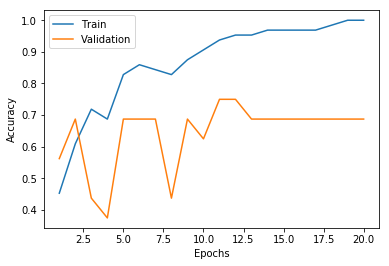

Test accuracy 0.800:


In [24]:
def main(shaip):
    shaip = ShaipWorkspace()
    cohort = Cohort(shaip)
    
    show_images(cohort, 'example_images.png')
    explore_cohort(cohort, 'summary_info.txt')
    
    ppch = PreprocessedCohort(cohort)
    x_data = data_scaling(ppch.images)
    y_data = keras.utils.to_categorical(ppch.groundtruth, 2)
    ids = ppch.ids
    
    

    x_train, x_test, y_train, y_test, ids_train, ids_test= \
        train_test_split(x_data, y_data, ids, 
                         test_size=0.20, shuffle=True, random_state=21)

    print("Training set: %d class 0, %d class 1" % (np.sum(y_train[:,0]), np.sum(y_train[:,1])))
    print("Testing set:  %d class 0, %d class 1" % (np.sum(y_test[:,0]), np.sum(y_test[:,1])))
    
    input_shape = PreprocessedCohort.imshape
    model = build_model(input_shape)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    history = AccuracyHistory()
    
    model.fit(x_train, y_train,
              batch_size=20,
              shuffle=True,
              epochs=20,
              verbose=2,
              validation_split=0.2,
              callbacks=[history])
    
    save_model(model, shaip.models_dir + 'model')
    
    history.plot_training()
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    # Output some results
    
    result = 'Test accuracy: %5.3f' % score[1]
    print(result)
    with open(shaip.results_dir + 'score.txt', 'w') as scorefp:
        scorefp.write(result)
        
    
# Lets do it!
main(ShaipWorkspace())
    